In [358]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from tqdm import tqdm
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [359]:
def kernel_function_matrix(kernel_function, x,d):
    # input x should be a (n,) vector
    kernel_function2 = lambda x1,x2: kernel_function(x1,x2,d)
    n = x.shape[0]
    res = np.zeros((n,n),dtype = np.double)
    for i in range(n):
        for j in range(n):
            res[i,j] = kernel_function2(x[i],x[j])
    return res
    
def leave_one_out_CV(KSS, X,y, true_f,ds, lmbdas,kernel_func):
    lmbda_opt = None; d_opt = None; error_opt = 100000000;
    n = X.shape[0]
    for d in tqdm(ds) :
        for lmbda in lmbdas:
            KSS.lmbda = lmbda
            l2 = []
            for i in range(n):
                KSS.theta = None;
                KSS.prediction = None;
                X_cp = X[np.arange(n)!=i]
                y_cp = y[np.arange(n)!=i]
                K = kernel_function_matrix(kernel_func,X_cp,d)
                KSS.train(K,y_cp)
                KSS.predict(kernel_func,X[i],X_cp,d)
                l2.append(KSS.prediction)
            mse_error = 1/n * np.sum(np.power(true_f - np.array(l2),2))
            if (mse_error < error_opt) :
                error_opt = mse_error
                d_opt = d
                lmbda_opt = lmbda
    return lmbda_opt,d_opt,error_opt
                
def bootstrap(KRR,X,resample_size,y,kernel_func,d,B,lmbda):
    '''
    d is the hyperparameter 
    B is number of bootstraps
    KRR the kernel reg object
    
    return value : B-by-resample_size list/matrix
    '''
    KRR.lmbda = lmbda
    res = []
    for i in range(B):
        pred = []
        KRR.theta = None
        KRR.prediction = None
        selector = np.random.choice(30, 30,replace=True)
        X_selected = X[selector]
        y_selected = y[selector]
        K = kernel_function_matrix(kernel_func,X_selected,d)
        KRR.train(K,y_selected)
        for x in X: 
            KRR.predict(kernel_func,x,X_selected,d)
            pred.append(KRR.prediction)
        res.append(pred)
    return res

In [360]:
class KernelRedgeReg:
    def __init__(self, lmbda, theta = None):
        self.lmbda = lmbda
        self.theta = theta
        self.prediction = None
        
    def train(self,K, y):
        n = y.shape[0]
        
        self.theta = linalg.solve(K + self.lmbda * 
                                  np.eye(n,dtype = np.double), y)  # A\b
    
    def predict(self,kernel_func, test_x, train_x,d):
        kernel_func2 = lambda x1: kernel_func(x1,test_x,d)
        prediction = 0
        for a, x in zip(self.theta, train_x):
            prediction += a * kernel_func2(x)
        self.prediction = prediction
        
        
        

In [396]:
##########################################################
######### construct X f(X) y #############################
##########################################################
d = 30;n = 30

X =np.sort(np.random.uniform(0,1,30))
f = lambda x : 4 * np.sin(np.pi * x) * np.cos(6* np.pi * x**2)
y = f(X) + np.random.normal(0,1,30)


In [397]:
###########################################################
######## kernel function: exp(-d(x-z)**2)##################
###########################################################
#kernel_func = lambda x1,x2,d: (1 + x1*x2)**d
kernel_func_1 = lambda x1,x2,d: np.exp(-d*np.power((x1 - x2),2))
#K_1 = kernel_function_matrix(kernel_func,X,d)

################ init a new KRR obj #######################
KRR_1 = KernelRedgeReg(lmbda=None)

################ hyper-parameters #########################
ds_1 = np.arange(1,100,5)
lmbdas_1 = np.arange(0,.5,0.01)

################ fit LOOCV ################################
lmbda_opt_1,d_opt_1,error_opt_1 = leave_one_out_CV\
    (KRR_1, X, y, f(X),ds_1, lmbdas_1,kernel_func_1)

100%|██████████| 20/20 [03:22<00:00, 10.12s/it]


In [398]:
##############################################################
############## A3 (a_1): kernel_func = exp(-d(x-z)**2)########
##############################################################

In [399]:

print("the optimal lambda value is {}".format(lmbda_opt_1))
print("the optimal d value is {}".format(d_opt_1))
print("the optimal error is {}".format(error_opt_1))


the optimal lambda value is 0.07
the optimal d value is 96
the optimal error is 0.1521915556100616


In [400]:
##############################################################
##### A3 (b_1):  kernel_func = exp(-d(x-z)**2)################
##############################################################

In [401]:


########## USING the optimal values to train the whole data set
KRR_1.lmbda = lmbda_opt_1
K_opt_1 = kernel_function_matrix(kernel_func_1,X,d_opt_1)
KRR.train(K_opt_1,y)
pred_list_1 =[]

########## predict the training set ###########################
for m in X: 
    KRR.predict(kernel_func_1,m,X,d_opt_1) 
    pred_list_1.append(KRR.prediction)

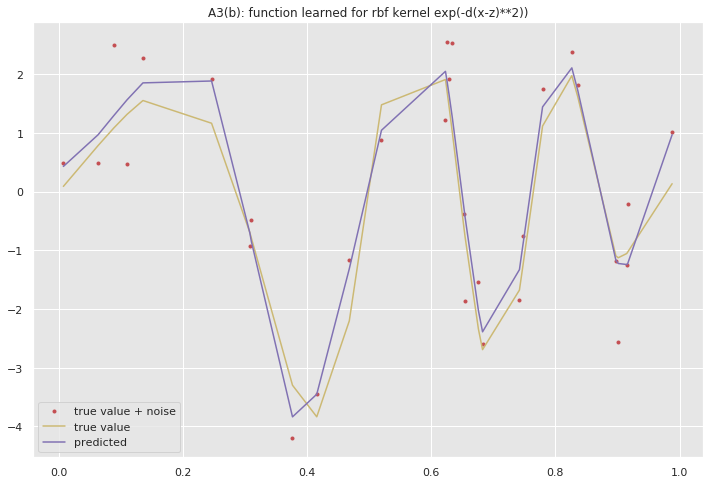

In [437]:
########### plot the training error ############################
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(12,8)) 
plt.plot(X,y,"r.")
plt.plot(X,f(X),"y-")
plt.plot(X,pred_list_1,'m-')
plt.title('A3(b): function learned for rbf kernel exp(-d(x-z)**2))')
plt.legend(['true value + noise','true value','predicted'])

#plt.savefig('A3b_rbf')

In [457]:
###########################################################
######## kernel function: (1 +xx')^d ######################
###########################################################
kernel_func_2 = lambda x1,x2,d: (1 + x1*x2)**d

#K_2 = kernel_function_matrix(kernel_func_2,X,d)

################ init a new KRR obj #######################
KRR_2 = KernelRedgeReg(lmbda=None)

################ hyper-parameters #########################
ds_2 = np.arange(20,50,3)
lmbdas_2 =np.arange(0.001,.2,0.001)

################ fit LOOCV ################################
lmbda_opt_2,d_opt_2,error_opt_2 = leave_one_out_CV\
    (KRR_2, X, y, f(X),ds_2, lmbdas_2,kernel_func_2)

100%|██████████| 10/10 [01:06<00:00,  6.61s/it]


In [458]:
##############################################################
############## A3 (a_2): kernel_func = (1 +xx')^d ############
##############################################################

In [459]:
print("the optimal lambda value is {}".format(lmbda_opt_2))
print("the optimal d value is {}".format(d_opt_2))
print("the optimal error is {}".format(error_opt_2))

the optimal lambda value is 0.137
the optimal d value is 41
the optimal error is 0.39018164835633473


In [460]:
##############################################################
##### A3 (b_2):  kernel_func = (1 +xx')^d   ##################
##############################################################

In [461]:


########## USING the optimal values to train the whole data set
KRR_2.lmbda = lmbda_opt_2
K_opt_2 = kernel_function_matrix(kernel_func_2,X,d_opt_2)
KRR_2.train(K_opt_2,y)
pred_list_2 =[]

########## predict the training set ###########################
for m in X: 
    KRR_2.predict(kernel_func_2,m,X,d_opt_2) 
    pred_list_2.append(KRR_2.prediction)

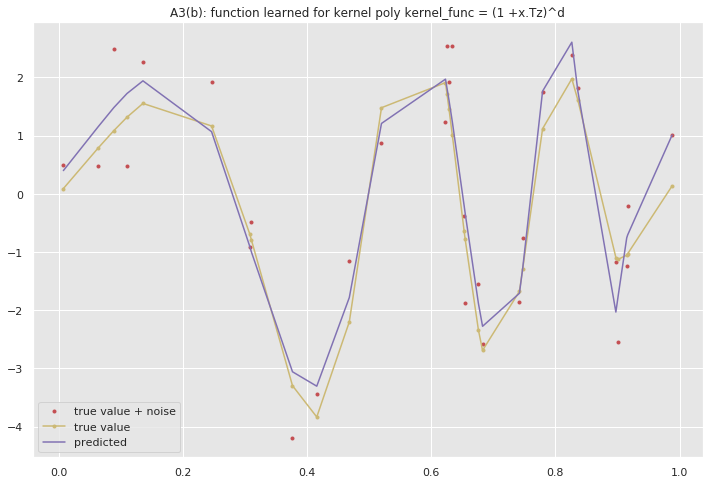

In [462]:
########### plot the training error ############################
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.axes_style("darkgrid")
plt.figure(figsize=(12,8)) 
plt.plot(X,y,"r.")
plt.plot(X,f(X),"y.-")
plt.plot(X,pred_list_2,'m-')
plt.title('A3(b): function learned for kernel poly kernel_func = (1 +x.Tz)^d')
plt.legend(['true value + noise','true value','predicted'])
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
#plt.savefig('A3b_poly')

In [421]:
##############################################################
###################### A3 (c) ################################
##############################################################

In [422]:
n_c = 30;B_c=300;d_c =d_opt_1; lmbda_c=lmbda_opt_1
resample_size =30
kernel_func_c = kernel_func_1
KRR_c = KernelRedgeReg(lmbda=None)

In [423]:
A3_c = bootstrap(KRR_c,X,resample_size,y,kernel_func_c,d_c,B_c,lmbda_c)

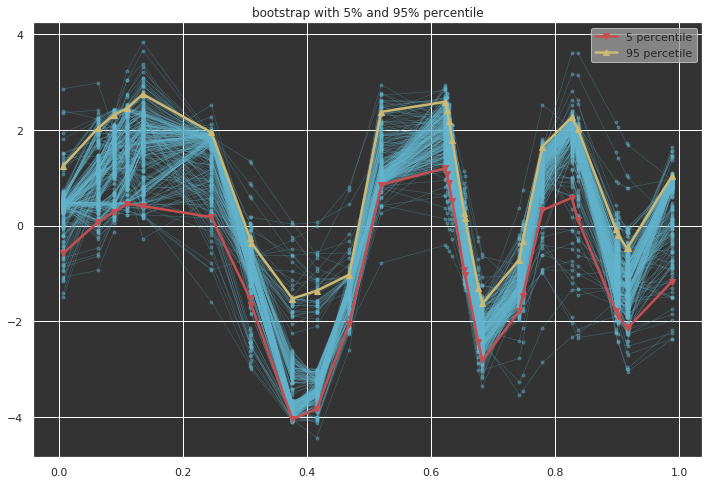

In [439]:
plt.figure(figsize=(12,8))
sns.set_style("darkgrid", {"axes.facecolor": ".2"})
for l in A3_c:
    plt.plot(X,l,'c.-',alpha = 0.4,linewidth=.5)
A3_arr = np.asarray(A3_c, dtype=np.double)
percentile_5 = np.percentile(A3_arr, q = 5, axis = 0)
percentile_95 = np.percentile(A3_arr, q = 95, axis = 0)
plt.plot(X, percentile_5 , 'r-v',alpha =1, linewidth = 2.5, label = '5 percentile')
plt.plot(X, percentile_95 , 'y-^',alpha = 1,linewidth = 2.5,label='95 percetile')

sns.set_style("darkgrid", {"axes.facecolor": ".6"})
plt.legend()
plt.title("bootstrap with 5% and 95% percentile")
#plt.plot(X_c,f(X_c),'k.-')
#plt.savefig('A3c_1')

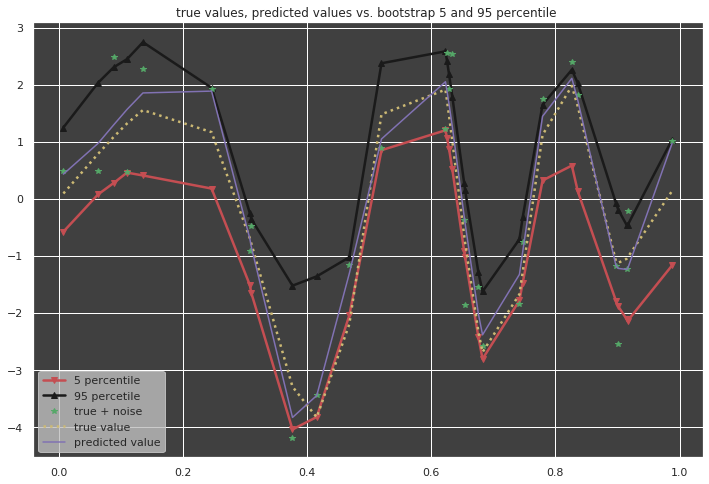

In [443]:
plt.figure(figsize=(12,8)) 
sns.set_style("darkgrid", {"axes.facecolor": ".25"})
plt.plot(X, percentile_5 , 'r-v',alpha =1, linewidth = 2.5, label = '5 percentile')
plt.plot(X, percentile_95 , 'k-^',alpha = 1,linewidth = 2.5,label='95 percetile')
plt.plot(X,y,"g*", label = 'true + noise' )
plt.plot(X,f(X),"y:", label = 'true value',linewidth = 2.5)
plt.plot(X,pred_list_1,'m-',label = "predicted value")
sns.set_style("darkgrid", {"axes.facecolor": ".75"})
plt.legend()
plt.title("true values, predicted values vs. bootstrap 5 and 95 percentile ")
#plt.savefig('A3c_2')

In [120]:
percentile_5

(300,)

In [427]:
##############################################################
###################### A3 (c): kernel poly ################################
##############################################################

In [463]:
n_c = 30;B_c=300;d_c =d_opt_2; lmbda_c=lmbda_opt_2
resample_size =30
kernel_func_2 = lambda x1,x2,d: (1 + x1*x2)**d
kernel_func_c = kernel_func_2
KRR_c = KernelRedgeReg(lmbda=None)

In [464]:
lmbda_opt_2

0.137

In [468]:
A3_c_2 = bootstrap(KRR_c,X,resample_size,y,kernel_func_c,d_c,B_c,lmbda_c)

Text(0.5, 1.0, 'bootstrap with 5% and 95% percentile')

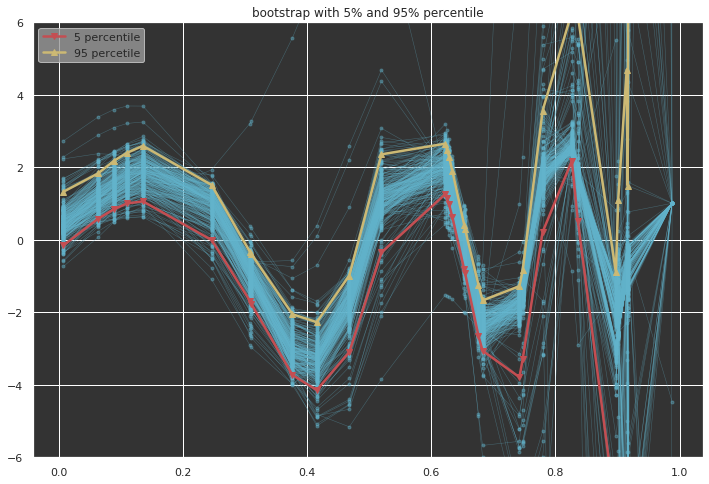

In [469]:
plt.figure(figsize=(12,8))
sns.set_style("darkgrid", {"axes.facecolor": ".2"})
for l in A3_c_2:
    plt.plot(X,l,'c.-',alpha = 0.4,linewidth=.5)
plt.ylim([-6,6])
A3_arr_2 = np.asarray(A3_c_2, dtype=np.double)
percentile_5_2 = np.percentile(A3_arr_2, q = 5, axis = 0)
percentile_95_2 = np.percentile(A3_arr_2, q = 95, axis = 0)
plt.plot(X, percentile_5_2 , 'r-v',alpha =1, linewidth = 2.5, label = '5 percentile')
plt.plot(X, percentile_95_2 , 'y-^',alpha = 1,linewidth = 2.5,label='95 percetile')

sns.set_style("darkgrid", {"axes.facecolor": ".6"})
plt.legend()
plt.title("bootstrap with 5% and 95% percentile")
#plt.plot(X_c,f(X_c),'k.-')
#plt.savefig('A3c_poly1')

Text(0.5, 1.0, 'true values, predicted values vs. bootstrap 5 and 95 percentile ')

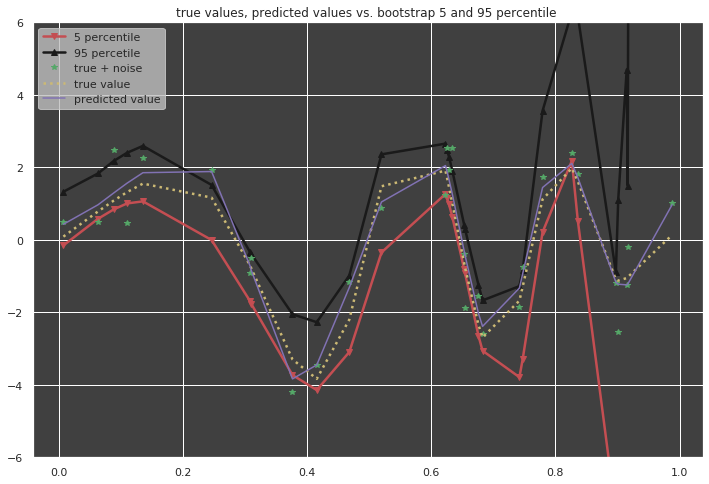

In [470]:
plt.figure(figsize=(12,8)) 
sns.set_style("darkgrid", {"axes.facecolor": ".25"})
plt.ylim([-6,6])
plt.plot(X, percentile_5_2 , 'r-v',alpha =1, linewidth = 2.5, label = '5 percentile')
plt.plot(X, percentile_95_2 , 'k-^',alpha = 1,linewidth = 2.5,label='95 percetile')
plt.plot(X,y,"g*", label = 'true + noise' )
plt.plot(X,f(X),"y:", label = 'true value',linewidth = 2.5)
plt.plot(X,pred_list_1,'m-',label = "predicted value")
sns.set_style("darkgrid", {"axes.facecolor": ".75"})
plt.legend()
plt.title("true values, predicted values vs. bootstrap 5 and 95 percentile ")
#plt.savefig('A3c_poly2')